In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
import plotly.express as px
import nbformat
import plotly.io as pio
pio.renderers.default = 'browser'
import folium
import webbrowser
import reportlab
import plotly.graph_objects as go
import plotly.offline as pyo
import html
from IPython.display import display, HTML



In [2]:
# Load data from a CSV file
df = pd.read_csv(r'C:\Users\izama\Desktop\immo-eliza-team6-analysis\immo-eliza-team6-analysis\analysis\clean_data_no_outliers.csv')

Text(0.5, 1.0, 'Prices in Belgium')

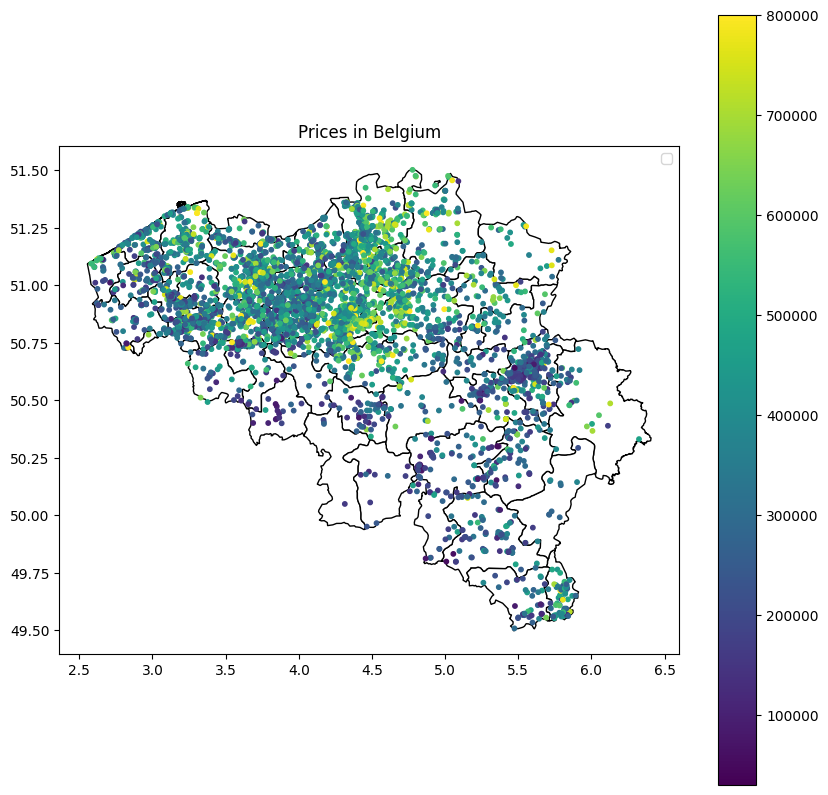

In [34]:
# Creating point geometry with Longitude and Latitude
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Setting the reference frame (CRS), e.g. EPSG:4326
gdf.set_crs(epsg=4326, inplace=True)

# Load administrative boundaries (e.g. Belgium)
# Replace 'path/to/belgium_shapefile.shp' with the path to your file
# Downloaded from: https://gadm.org/download_country.html#google_vignette
borders = gpd.read_file(r"C:\Users\izama\Desktop\gadm41_BEL_shp\gadm41_BEL_3.shp")

# Set the frame of reference for the boundaries if different (for example EPSG:4326)
#borders = borders.to_crs(epsg=4326)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Draw administrative boundaries on the map
borders.plot(ax=ax, color='white', edgecolor='black', linewidth=1) 

# Draw price points (Price)
scatter = gdf.plot(ax=ax, 
                   column='Price', 
                   cmap='viridis',  # Color map
                   legend=True, 
                   markersize=10)

# Add a legend
handles, labels = scatter.get_legend_handles_labels()
ax.legend(handles, [f'{int(float(label))}' for label in labels])

plt.title('Prices in Belgium')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.grid()
#plt.show()


**Correlation of real estate features (Seaborn)**

Correlation matrix to examine the correlations between different numeric variables 
like Price, Number_of_bedrooms, Living_area, Number_of_facades, etc.

<Axes: >

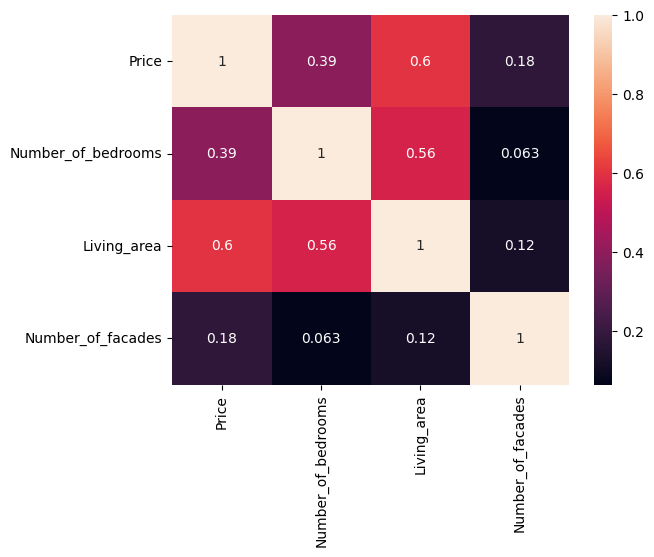

In [35]:
sns.heatmap(df[['Price', 'Number_of_bedrooms', 'Living_area', 'Number_of_facades']].corr(), annot=True)


**Histogram of real estate price distribution (Seaborn)**

Create a histogram showing the price distribution (Price) for different property types 
(Subtype) to see what prices dominate for different building types.

<Axes: xlabel='Price', ylabel='Count'>

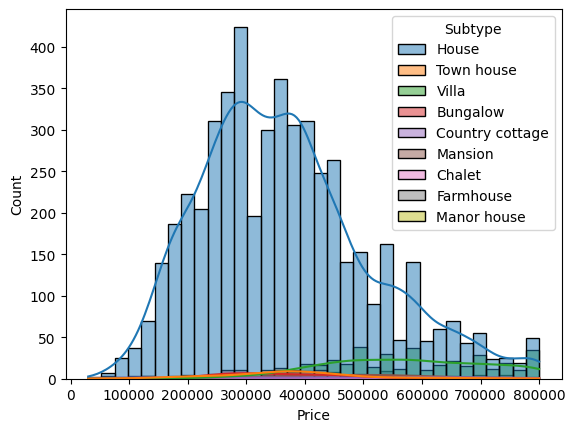

In [36]:
sns.histplot(data=df, x='Price', hue='Subtype', kde=True)

**Relationship between number of bedrooms and price (Seaborn)**

A scatterplot showing the relationship between Number_of_bedrooms and Price to see how the number of bedrooms affects price.

<Axes: xlabel='Number_of_bedrooms', ylabel='Price'>

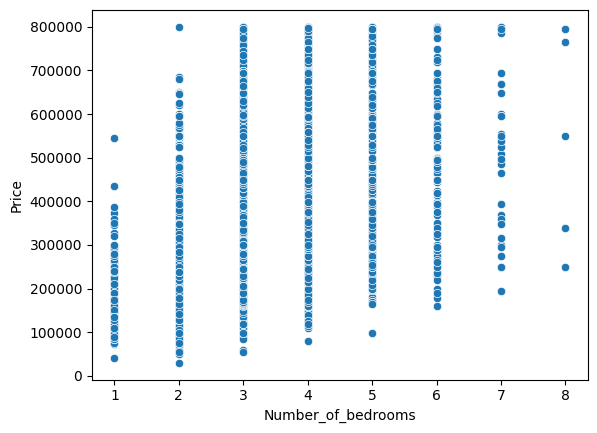

In [37]:
sns.scatterplot(data=df, x='Number_of_bedrooms', y='Price')


**Distribution of price per square meter (price_per_sqm) in different locations (Plotly)**

An interactive boxplot that shows the distribution of price per square meter (price_per_sqm) across different locations (locality_name).

In [38]:
fig = px.box(df, x='locality_name', y='price_per_sqm')
fig.show()


**Bar chart of number of rooms vs. living area (Seaborn)**

Bar chart showing average living area (Living_area) versus number of rooms (Number_of_bedrooms)

<Axes: xlabel='Number_of_bedrooms', ylabel='Living_area'>

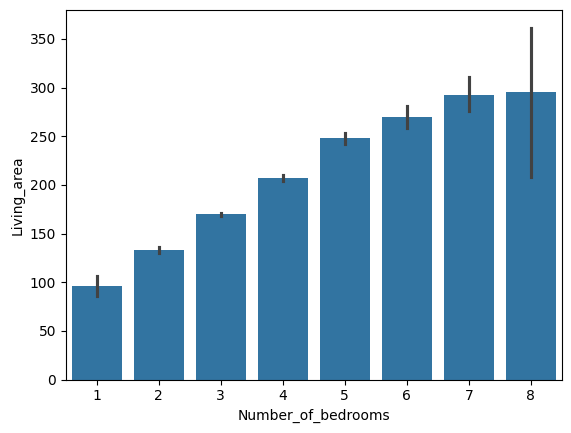

In [39]:
sns.barplot(data=df, x='Number_of_bedrooms', y='Living_area')


**The relationship between the condition of the building and the price**

The relationship between State_of_building and Price to see how the state of the building affects the value of the property.

<Axes: xlabel='State_of_building', ylabel='Price'>

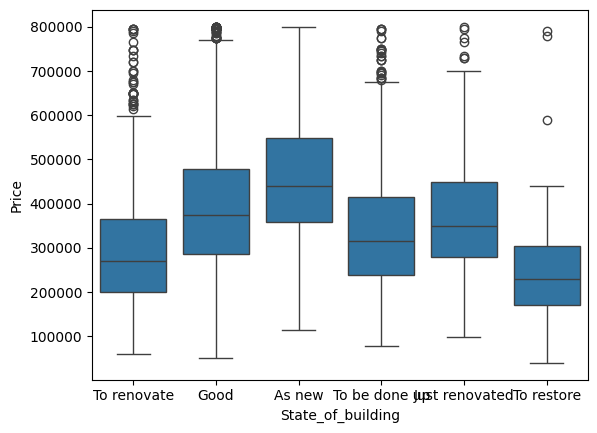

In [10]:
sns.boxplot(data=df, x='State_of_building', y='Price')


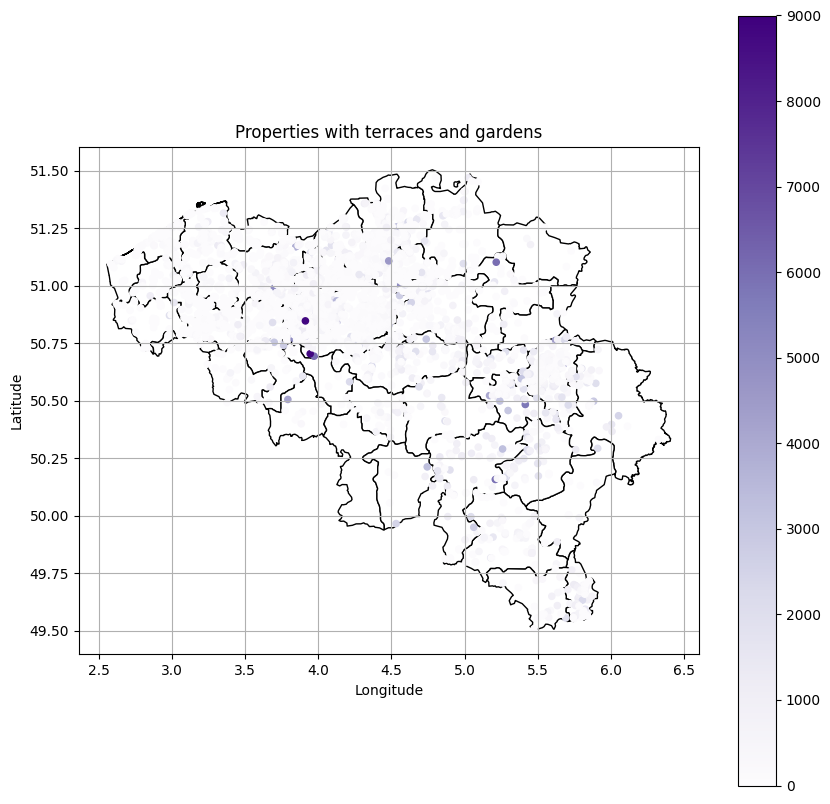

In [11]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)
borders = gpd.read_file(r"C:\Users\izama\Desktop\gadm41_BEL_shp\gadm41_BEL_3.shp")

gdf_with_terrace = gdf[gdf['hasTerrace'] == 1]

fig, ax = plt.subplots(figsize=(10, 10))

borders.plot(ax=ax, color='white', edgecolor='black', linewidth=1)

gdf_with_terrace.plot(column='gardenSurface', cmap='Purples', ax=ax, legend=True, markersize=20)

plt.title('Properties with terraces and gardens')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


In [41]:
fig = px.scatter(df, x='epc', y='Price',
                 size='Living_area', color='epc',
                 hover_name='locality_name', 
                 title='Price depending on the EPC',
                 labels={'epc': 'EPC', 'Price': 'Price'},
                 size_max=10)

fig.show()

In [ ]:
# Defining the order of EPC categories
epc_categories = ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']

# Sorting data by EPC category
df['epc'] = pd.Categorical(df['epc'], categories=epc_categories, ordered=True)
df_sorted = df.sort_values('epc')

# Create a scatter
fig = px.scatter(df_sorted, x='epc', y='Price',
                 size='Living_area', color='epc',
                 hover_name='locality_name', 
                 title='Price depending on the EPC',
                 labels={'epc': 'EPC', 'Price': 'Price'},
                 size_max=20,
                 category_orders={'epc': epc_categories})

#fig.show()

# Save the chart to an HTML file
plot_file = 'epc_price_scatter.html'
pyo.plot(fig, filename=plot_file, include_plotlyjs='cdn', auto_open=False)

# Load the chart into an interactive report
interactive_report = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Interactive Report</title>
</head>
<body>
    <h1>Interactive Report with EPC Price Scatter Plot</h1>
    <iframe src="{plot_file}" width="100%" height="600px"></iframe>
</body>
</html>
"""

# View the interactive report
#display(HTML(interactive_report))
#pio.show(fig)

In [5]:
import pandas as pd
import plotly.express as px
from IPython.display import display, HTML
import plotly.offline as pyo

# Definiowanie porządku kategorii EPC
epc_categories = ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']

# Zakładam, że masz już DataFrame `df`
# Sortowanie danych według kategorii EPC
df['epc'] = pd.Categorical(df['epc'], categories=epc_categories, ordered=True)
df_sorted = df.sort_values('epc')

# Tworzenie scatter plot
fig = px.scatter(df_sorted, x='epc', y='Price',
                 size='Living_area', color='epc',
                 hover_name='locality_name', 
                 title='Price depending on the EPC',
                 labels={'epc': 'EPC', 'Price': 'Price'},
                 size_max=20,
                 category_orders={'epc': epc_categories})

# Zapisz wykres do pliku HTML
plot_file = 'epc_price_scatter.html'
pyo.plot(fig, filename=plot_file, include_plotlyjs='cdn', auto_open=False)

# Odczytaj zawartość pliku HTML
with open(plot_file, 'r') as f:
    html_content = f.read()

# Wyświetl zawartość HTML
display(HTML(html_content))
pio.show(fig)


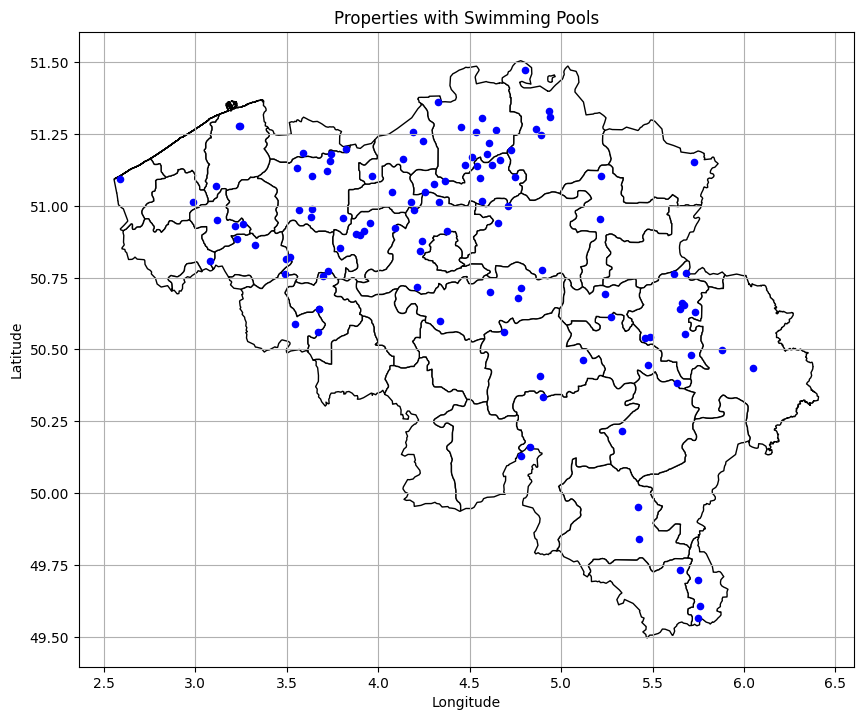

In [14]:
# Create a 'geometry' column from the longitude and latitude in the dataframe
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create a GeoDataFrame using the original dataframe 'df' and the geometry column
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the Coordinate Reference System (CRS) to WGS 84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Load the shapefile of Belgian borders (the path should point to your local file)
borders = gpd.read_file(r"C:\Users\izama\Desktop\gadm41_BEL_shp\gadm41_BEL_3.shp")

# Create a new plot figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the borders of Belgium with a white fill and black edges
borders.plot(ax=ax, color='white', edgecolor='black', linewidth=1)

# Filter the GeoDataFrame to get only properties with a swimming pool
gdf_with_pool = gdf[gdf['Swimming_Pool'] == 1]

# Plot the properties with swimming pools on top of the borders map
# Points will be blue and have a size of 20
gdf_with_pool.plot(ax=ax, color='blue', markersize=20)

# Add a title and axis labels to the plot
plt.title('Properties with Swimming Pools')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add grid lines to the plot for easier reference
plt.grid()

# Show the final plot
plt.show()


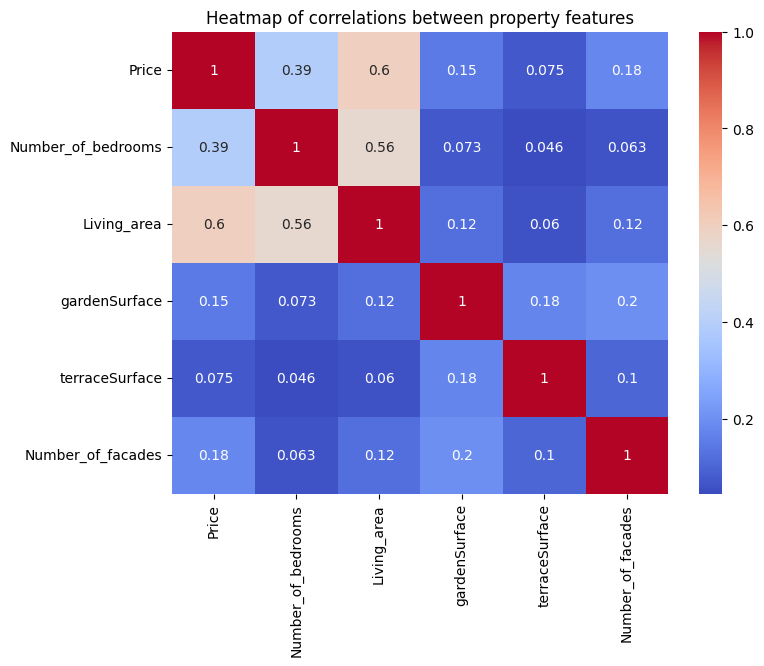

In [15]:
# Select interesting columns
corr_df = df[['Price', 'Number_of_bedrooms', 'Living_area', 'gardenSurface', 'terraceSurface', 'Number_of_facades']]

# Calculate correlations
corr_matrix = corr_df.corr()

# Create a heat map
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Heatmap of correlations between property features')
plt.show()


**Creating a histogram of real estate prices by building type**

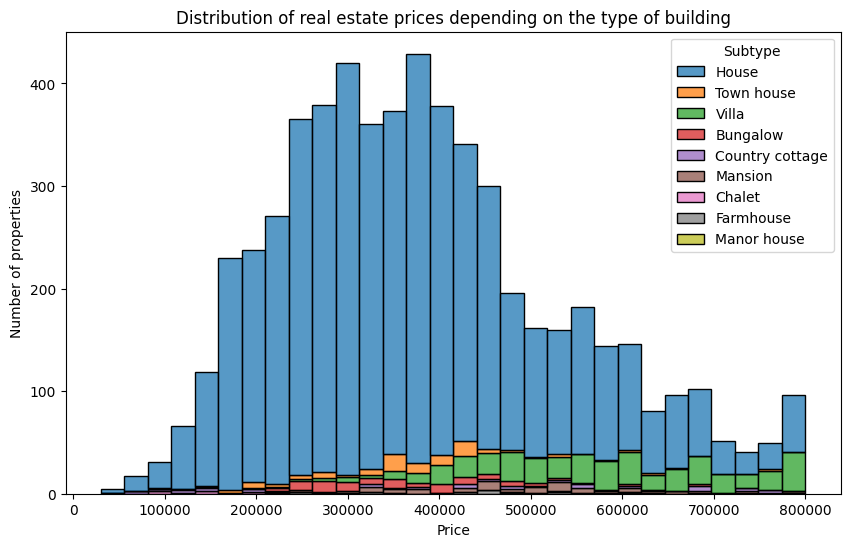

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Price', hue='Subtype', multiple='stack', bins=30)

plt.title('Distribution of real estate prices depending on the type of building')
plt.xlabel('Price')
plt.ylabel('Number of properties')
plt.show()

In [17]:
import plotly.express as px

# Create an interactive bar chart
fig = px.bar(df, x='State_of_building', y='price_per_sqm',
             title='Average price per m² depending on the condition of the building',
             labels={'State_of_building': 'State of building', 'price_per_sqm': 'Price per m²'},
             color='State_of_building')

fig.show()


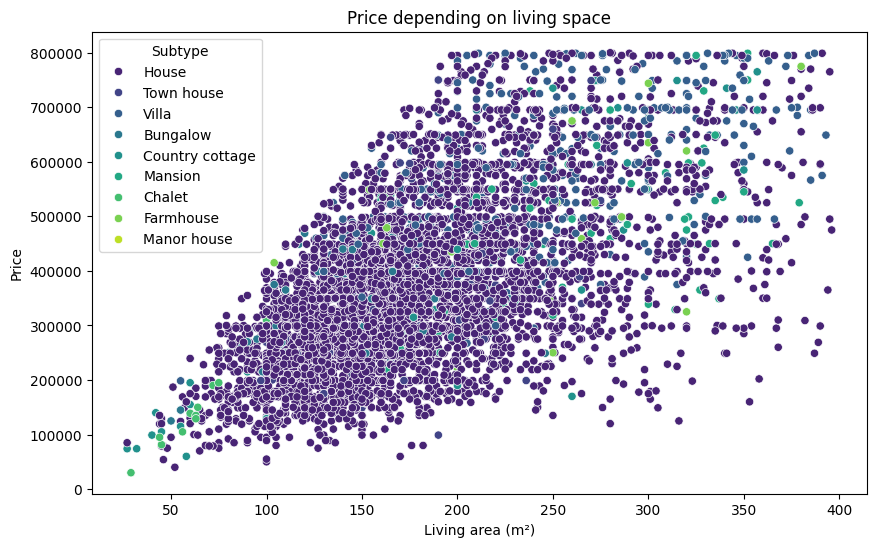

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Living_area', y='Price', hue='Subtype', palette='viridis')

plt.title('Price depending on living space')
plt.xlabel('Living area (m²)')
plt.ylabel('Price')
plt.show()


In [31]:
fig = px.density_mapbox(df, lat='latitude', lon='longitude', radius=10,
                        center=dict(lat=df.latitude.mean(), lon=df.longitude.mean()),
                        zoom=5, mapbox_style='open-street-map')
fig.show()

In [30]:
import folium
import numpy as np
import webbrowser
from folium.plugins import MarkerCluster

# Remove rows that have NaN in the latitude or longitude columns
df_clean = df.dropna(subset=['latitude', 'longitude'])

# Create a map with the appropriate center
properties = folium.Map(location=[df_clean['latitude'].mean(), df_clean['longitude'].mean()], zoom_start=10)

folium.TileLayer('Stamen Toner', attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap').add_to(properties)

# Add MarkerCluster to improve performance with large numbers of markers
marker_cluster = MarkerCluster().add_to(properties)

# Add tags to the cluster
for index, row in df_clean.iterrows():
    text = f"""
    Subtype: {row.Subtype}<br>
    Price: {row.Price}<br>
    Living Area: {row.Living_area} m²<br>
    Bedrooms: {row.Number_of_bedrooms}<br>
    Building State: {row.State_of_building}
    """
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=folium.Popup(text, max_width=400),
        tooltip=row['Subtype']
    ).add_to(marker_cluster)

properties

# Save map to the html
#map_path = r'C:\Users\izama\Desktop\map.html'
#properties.save(map_path)

# Open map in browser
#webbrowser.open(map_path)


# Save map to the PDF file


from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# Path to the HTML map
map_path = r'file:///C:/Users/izama/Desktop/map.html'

# Path to the generated PDF
pdf_path = r'C:\Users\izama\Desktop\report.pdf'

# Create a PDF object
pdf = canvas.Canvas(pdf_path, pagesize=letter)

# Add page 1 with text
pdf.drawString(100, 750, "Real Estate Market Analysis Report")
pdf.showPage()  # Create a new page

# Add page 2 and a link to the map
pdf.drawString(100, 750, "Click the link below to view the interactive map:")

# Define coordinates (bottom left corner, top right corner) for the link
# Here the link will be below the text, at position (100, 735) and will have a height of up to (500, 750)
pdf.linkURL(map_path, (100, 735, 500, 750), relative=0)

# Add additional text or other elements to the page
pdf.drawString(100, 730, "Interactive Real Estate Map")

# Save PDF
pdf.save()


In [28]:
#Converting the postal codes to dtype 'str'

df['Postal_code'] = df['Postal_code'].astype(str)

def get_province(postal_code):
    if postal_code.startswith('1'):
        return 'Brussels' if int(postal_code) < 1300 else 'Brabant_Wallon'
    elif postal_code.startswith('2'):
        return 'Antwerp'
    elif postal_code.startswith('4'):
        return 'Liège'
    elif postal_code.startswith('5'):
        return 'Namur'
    elif postal_code.startswith('6'):
        return 'Luxembourg'
    elif postal_code.startswith('7'):
        return 'Hainaut'
    elif postal_code.startswith('8'):
        return 'West Flanders'
    elif postal_code.startswith('9'):
        return 'East Flanders'
    elif postal_code.startswith('3'):
        return 'Flemish Brabant' if int(postal_code) < 3500 else 'Limburg'
    else:
        return None 

df['Province'] = df['Postal_code'].apply(get_province).copy()


In [29]:
import folium
import pandas as pd
import numpy as np

# Funkcja do określania współrzędnych dla każdej prowincji (przykładowe wartości)
province_coords = {
    'Brussels': [50.8503, 4.3517],
    'Brabant_Wallon': [50.7167, 4.6167],
    'Antwerp': [51.2194, 4.4025],
    'Liège': [50.6337, 5.5675],
    'Namur': [50.4669, 4.8675],
    'Luxembourg': [49.7333, 5.7333],
    'Hainaut': [50.4562, 3.9523],
    'West Flanders': [51.0512, 3.7303],
    'East Flanders': [51.0536, 3.7305],
    'Flemish Brabant': [50.8796, 4.7009],
    'Limburg': [50.9304, 5.3325]
}

# Zakładam, że Twoja kolumna `Postal_code` ma już prowincje
# Grupujemy dane według prowincji i obliczamy średnią cenę
province_prices = df.groupby('Province')['Price'].mean().reset_index()

# Stwórz mapę
province_map = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

# Dodaj markery dla każdej prowincji z informacjami o średniej cenie
for index, row in province_prices.iterrows():
    province = row['Province']
    avg_price = row['Price']
    
    if province in province_coords:
        # Pobierz współrzędne dla danej prowincji
        coords = province_coords[province]
        
        # Stwórz tekst popup z informacją o średniej cenie
        popup_text = f"<strong>{province}</strong><br>Average Price: €{avg_price:,.2f}"
        
        # Dodaj marker na mapie
        folium.Marker(
            location=coords,
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=province
        ).add_to(province_map)

# Zapisz mapę do pliku HTML
province_map.save('province_price_map.html')

# Wyświetl mapę
province_map
